In [7]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [8]:
import numpy as np
import torch
import os
import matplotlib.pylab as plt
from skimage import io, color
import pickle
from torch.serialization import default_restore_location
import argparse

import models
from helper_functions.helper_functions import show_img
from utils import *


c:\Users\lenonvo\Desktop\UniV COURS\Project Image\Pre_trained\utils\demo_utils.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, 

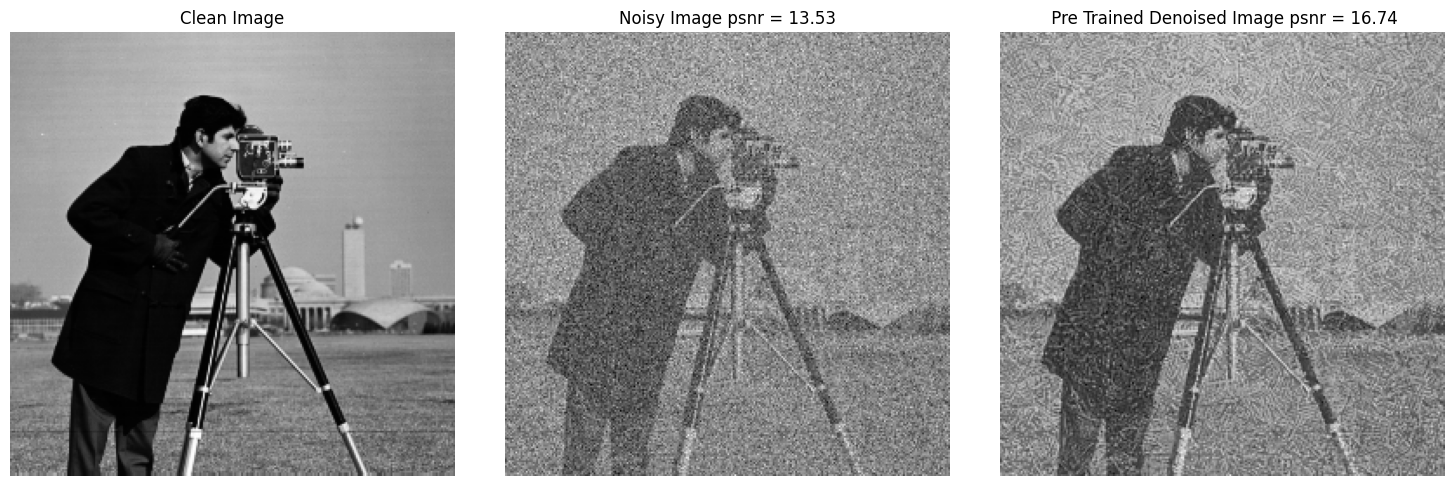

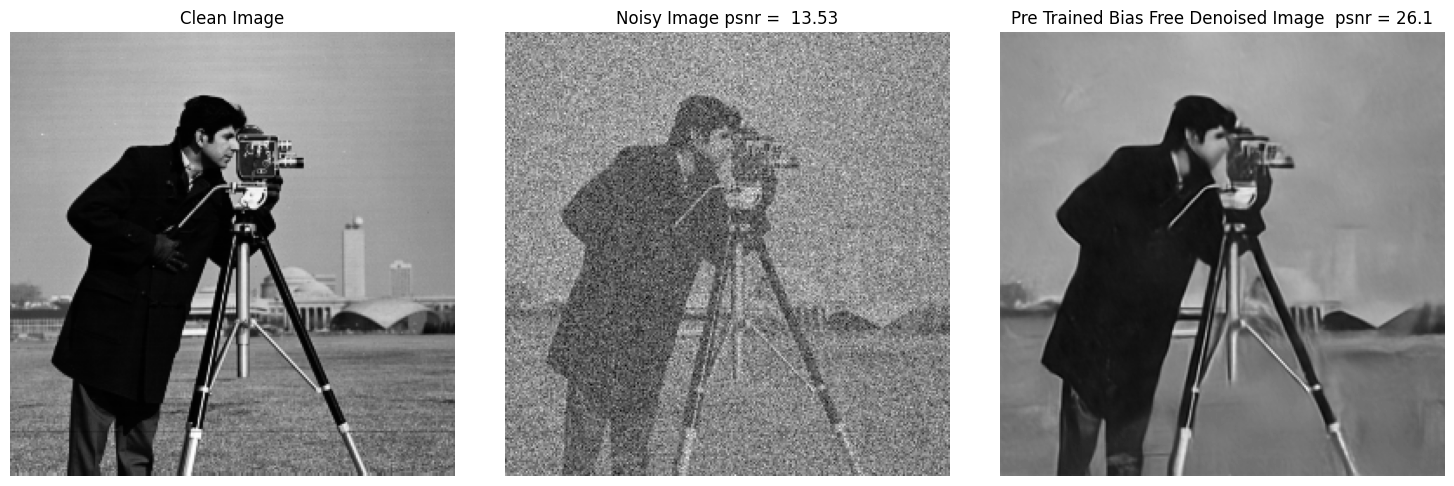

In [9]:
USE_CUDA = True
device = torch.device('cuda') if (torch.cuda.is_available() and USE_CUDA) else torch.device('cpu')

pretrained_base = './pretrained/'
precomputed_base = './precomputed/'
data_base = 'data/'


set12_path = os.path.join(data_base, 'Test/Set12/')


# Choose a model to load (options are: 'dncnn', 'unet', 'rcnn', 'sdensenet')
model = 'dncnn' 

# Select the range of training noise levels (stdev, relative to intensity range [0,255]). 
# Pre-computed options are 0-10, 0-30, 0-55, 0-100.
min_noise = 0   # lower bound of training range 
max_noise = 30  # upper bound of training range 
noise_level = 60

CNN = load_model(os.path.join(pretrained_base, model, 'bias', str(min_noise)+'-'+str(max_noise)+'.pt'))
BF_CNN = load_model(os.path.join(pretrained_base, model, 'bias_free', str(min_noise)+'-'+str(max_noise)+'.pt'))
img_path = '../test_images/cameraman.tif'

clean_im = io.imread(img_path).astype(float)/255

if len(clean_im.shape) == 3:
    clean_im = color.rgb2gray(clean_im)


clean_im_tensor = torch.from_numpy(clean_im).unsqueeze(0).unsqueeze(0).to(device).float()

noise = utils.get_noise(clean_im_tensor, noise_std = noise_level/255., mode='S')
inp_test = clean_im_tensor + noise;
noisy_im = inp_test.cpu().data.squeeze(0).squeeze(0).numpy()
noisy_psnr = np.round(utils.psnr(clean_im_tensor, inp_test), 2)


denoised_dncnn= CNN(inp_test)
denoised_dncnn_psnr = np.round(utils.psnr(clean_im_tensor, denoised_dncnn), 2)
denoised_dncnn = denoised_dncnn.cpu().data.squeeze(0).squeeze(0).numpy()


denoised_BF_dncnn= BF_CNN(inp_test)
denoised_BF_dncnn_psnr = np.round(utils.psnr(clean_im_tensor, denoised_BF_dncnn), 2)
denoised_BF_dncnn = denoised_BF_dncnn.cpu().data.squeeze(0).squeeze(0).numpy()

show_img(clean_im, noisy_im, denoised_dncnn, titles=['Clean Image',f'Noisy Image psnr = {noisy_psnr}',f' Pre Trained Denoised Image psnr = {denoised_dncnn_psnr}'])
show_img(clean_im, noisy_im, denoised_BF_dncnn, titles=['Clean Image',f'Noisy Image psnr =  {noisy_psnr}',f'Pre Trained Bias Free Denoised Image  psnr = {denoised_BF_dncnn_psnr}'])